# Multi-class classifier: MNIST images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

Let's use a subset of the well-known MNIST handwritten digits data set. This is like the "hello world" of image recognition for deep learning. 

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

In [6]:
X.shape

(10000, 784)

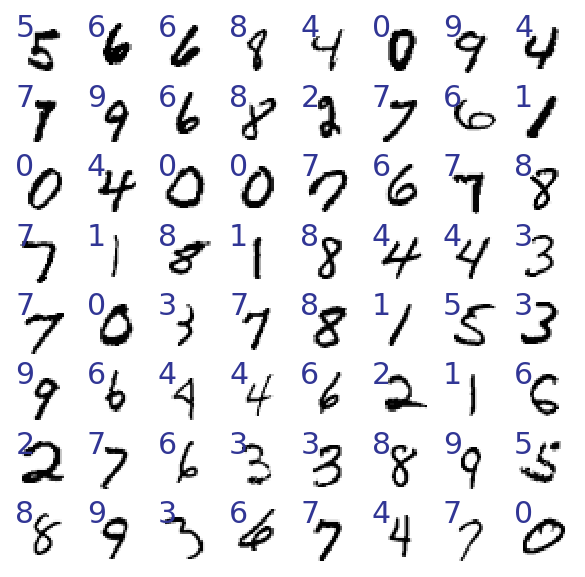

In [7]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

In [8]:
X = torch.tensor(X).float()
y = torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Random forest baseline

In [9]:
cl = RandomForestClassifier(n_estimators=900, n_jobs=-1)
cl.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [10]:
y_train_accuracy = cl.score(X_train, y_train)
y_accuracy = cl.score(X_test, y_test)
y_train_accuracy, y_accuracy

(1.0, 0.9765)

## Vanilla one hidden layer of 50 neurons, softmax on end

In [11]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [12]:
def ctrain0(model, X, y, learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y)
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:5d} cross entropy loss {loss:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")

In [13]:
model = nn.Sequential(
    nn.Linear(784, 50), # 50 neurons
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
).to(device)

In [14]:
ctrain0(model, X_train, y_train, learning_rate = .03, nepochs=1000)

Epoch     0 cross entropy loss  2.3037
Epoch   100 cross entropy loss  1.4847
Epoch   200 cross entropy loss  1.4799
Epoch   300 cross entropy loss  1.4797
Epoch   400 cross entropy loss  1.4790
Epoch   500 cross entropy loss  1.4786
Epoch   600 cross entropy loss  1.4784
Epoch   700 cross entropy loss  1.4766
Epoch   800 cross entropy loss  1.4760
Epoch   900 cross entropy loss  1.4753
Epoch  1000 cross entropy loss  1.4752
LAST        cross entropy loss  1.4752


In [15]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [16]:
conf = confusion_matrix(y_train.detach().cpu(), y_pred.detach().cpu())
print(conf)

[[839   0   0   0   0   0   0   0   3   0]
 [  0 815   4   2   2   0   0   0   0   0]
 [  3   0 757   1   2   0   4   7   2   0]
 [  0   1   1 807   0   2   0   0   8   5]
 [  1   1   0   0 738   0   0   0   2   3]
 [  1   0   1   1   2 746   4   0   4   1]
 [  1   0   0   0   0   1 750   0   1   1]
 [  0   2   0   0  10   0   0 890   0   3]
 [  0   0   1   1   4   0   0   0 804   1]
 [  4   0   1   3   4   1   0   6   2 739]]


In [17]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.957


In [18]:
conf = confusion_matrix(y_test.detach().cpu(), y_test_pred.detach().cpu())
print(conf)

[[177   0   0   0   1   0   0   0   1   0]
 [  0 210   1   0   1   0   1   0   0   0]
 [  0   0 199   2   0   0   3   1   4   0]
 [  0   0   0 170   0   7   0   0   3   4]
 [  1   0   0   0 189   0   0   0   1   7]
 [  0   0   0   4   0 166   3   0   0   0]
 [  2   1   0   0   0   2 195   0   0   0]
 [  0   2   1   1   2   0   0 231   1   2]
 [  1   3   0   1   0   2   0   1 176   1]
 [  2   0   1   3   6   3   0   1   2 201]]


## Track validation versus training loss

In [19]:
def ctrain1(model, X_train, y_train, X_test, y_test, 
            learning_rate = .0001, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)

        with torch.no_grad():
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss.detach(), loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [20]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
).to(device)

In [21]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = .03, nepochs=1000)

Epoch    0 cross entropy loss  2.3030   test loss  2.3031
Epoch  100 cross entropy loss  1.4849   test loss  1.5131
Epoch  200 cross entropy loss  1.4796   test loss  1.5073
Epoch  300 cross entropy loss  1.4783   test loss  1.5076
Epoch  400 cross entropy loss  1.4775   test loss  1.5045
Epoch  500 cross entropy loss  1.4773   test loss  1.5046
Epoch  600 cross entropy loss  1.4762   test loss  1.5045
Epoch  700 cross entropy loss  1.4756   test loss  1.5051
Epoch  800 cross entropy loss  1.4753   test loss  1.5039
Epoch  900 cross entropy loss  1.4750   test loss  1.5034
Epoch 1000 cross entropy loss  1.4750   test loss  1.5034
LAST        cross entropy loss  1.4750


In [22]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [23]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.956


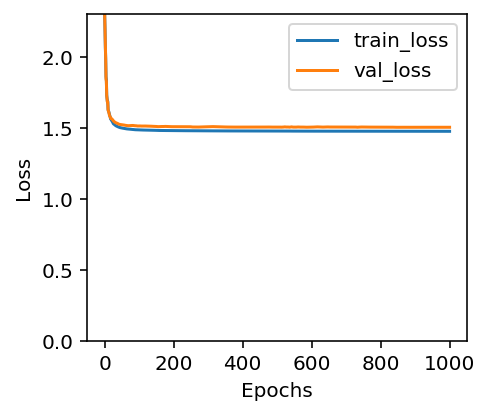

In [24]:
plot_loss(history)

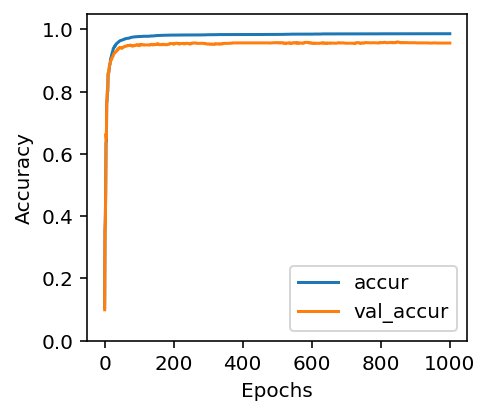

In [25]:
plot_accur(history)

## Use many neurons

In [115]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
).to(device)

In [116]:
history = ctrain1(model, X_train, y_train, X_test, y_test,
                  learning_rate = 0.003, nepochs=10000)

Epoch    0 cross entropy loss  2.3027   test loss  2.3029
Epoch 1000 cross entropy loss  1.4721   test loss  1.4953
Epoch 2000 cross entropy loss  1.4687   test loss  1.4924
Epoch 3000 cross entropy loss  1.4682   test loss  1.4925
Epoch 4000 cross entropy loss  1.4681   test loss  1.4915
Epoch 5000 cross entropy loss  1.4681   test loss  1.4915
Epoch 6000 cross entropy loss  1.4671   test loss  1.4888
Epoch 7000 cross entropy loss  1.4669   test loss  1.4881
Epoch 8000 cross entropy loss  1.4668   test loss  1.4873
Epoch 9000 cross entropy loss  1.4668   test loss  1.4873
Epoch 10000 cross entropy loss  1.4668   test loss  1.4874
LAST        cross entropy loss  1.4668


In [117]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.994


In [118]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.974


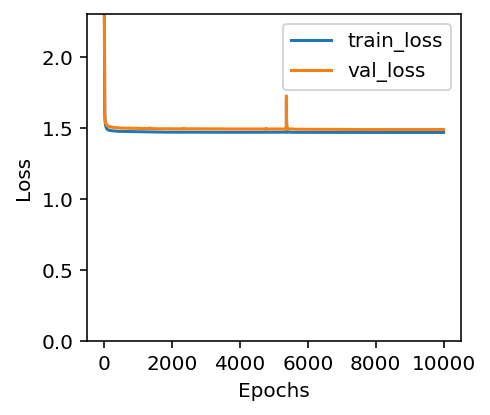

In [119]:
plot_loss(history)

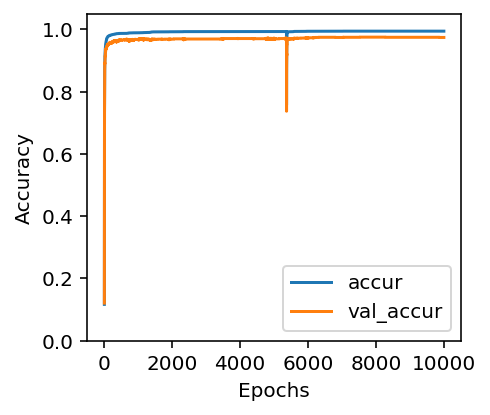

In [120]:
plot_accur(history)

## Cyclic learning rate

In [82]:
def ctrain2(model, X_train, y_train, X_test, y_test, 
            nepochs=2000,
            base_lr=0.01, max_lr=0.05):
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                  mode='triangular2',
                                                  step_size_up=500,
                                                  base_lr=base_lr, max_lr=max_lr,
                                                  cycle_momentum=False)
    history = []
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        # Assume model yields softmax probabilities
        loss = F.cross_entropy(y_pred, y_train)
        
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        history.append((loss.detach(), loss_test, accur, loss_accur))
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}   LR {scheduler.get_last_lr()[0]:7.6f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
        scheduler.step()
        
    print(f"LAST        cross entropy loss {loss:7.4f}")
    return torch.tensor(history)

In [93]:
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
).to(device)

In [94]:
history = ctrain2(model, X_train, y_train, X_test, y_test,
                  base_lr=0.002, max_lr=0.02, nepochs=3000)

Epoch    0 cross entropy loss  2.3027   test loss  2.3026   LR 0.002000
Epoch  300 cross entropy loss  1.4718   test loss  1.4936   LR 0.012800
Epoch  600 cross entropy loss  1.4698   test loss  1.4916   LR 0.016400
Epoch  900 cross entropy loss  1.4692   test loss  1.4914   LR 0.005600
Epoch 1200 cross entropy loss  1.4692   test loss  1.4914   LR 0.005600
Epoch 1500 cross entropy loss  1.4692   test loss  1.4916   LR 0.011000
Epoch 1800 cross entropy loss  1.4692   test loss  1.4915   LR 0.005600
Epoch 2100 cross entropy loss  1.4689   test loss  1.4912   LR 0.002900
Epoch 2400 cross entropy loss  1.4686   test loss  1.4901   LR 0.005600
Epoch 2700 cross entropy loss  1.4686   test loss  1.4901   LR 0.004700
Epoch 3000 cross entropy loss  1.4686   test loss  1.4901   LR 0.002000
LAST        cross entropy loss  1.4686


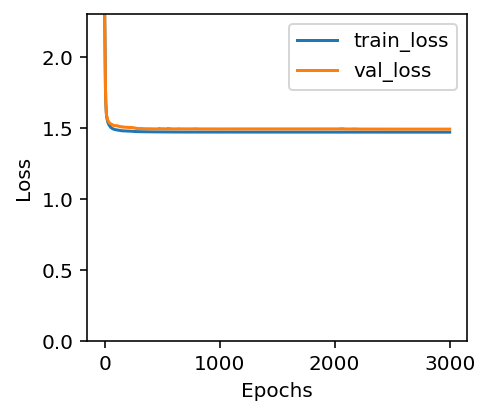

In [95]:
plot_loss(history)

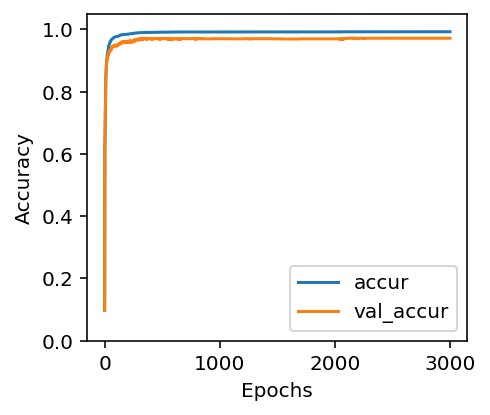

In [96]:
plot_accur(history)